In [1]:
import numpy as np
from quadratures import get_lebedev
from tools_old import project_density, plot_density_projections, get_density_feats
from tools import interpolate_density, cartesian_to_spherical_angles, get_basis_poly, lsq_sph_coeffs, reconstructor
import qe_density_reader.reader as qer
from os.path import join as pjoin   

from scipy.linalg import lstsq
import matplotlib.pyplot as plt
from grid.utils import generate_real_spherical_harmonics as grsh

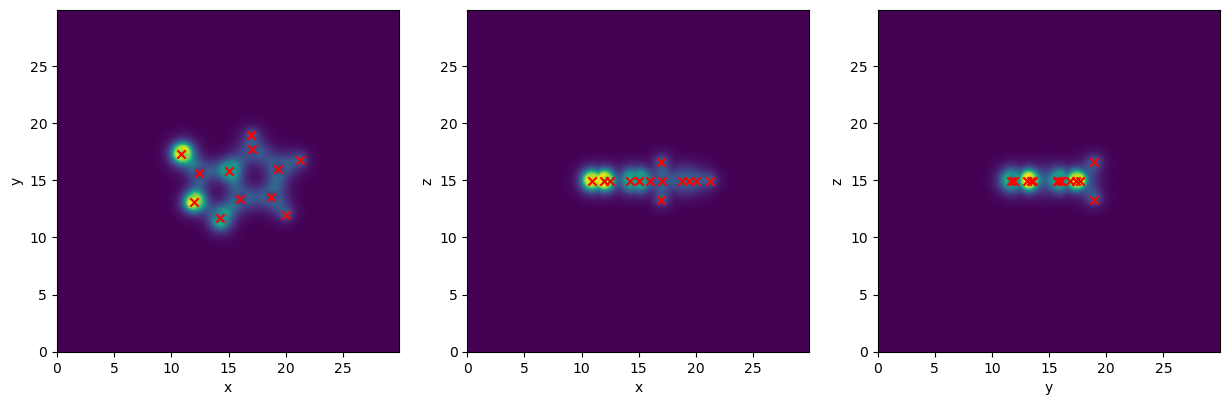

In [2]:
# Load and plot data
DIRPATH = "/home/sp2120/rds/rds-pdb_dist-PDSVOqhVGhM/data/qm9/dsgdb9nsd_atom15_out"
dens = qer.Density(pjoin(DIRPATH, "dsgdb9nsd_130767.hdf5"))

fig, ax = plot_density_projections(project_density(dens.rho), dens.atoms_positions, dens.alat)
# ax[2].set_ylim(10, 20)
# ax[2].set_xlim(10, 20)

# Atom centred representation

We wish to represent our 3D electron density data as a family of local atom centred representations. A natural for this are spherical harmonics (SH) which, together with a radial basis function (RBF) can form an orthonormal basis for $\mathbb{R}^3$. Formally, we can represent our electron density data ($\rho(r)$) as:

$$
\rho(\boldsymbol{r})=\sum_{n l m} c_{n l m} g_n(r) Y_{l m}(\theta, \phi)
$$
Where $Y_{l m}$ are the *real* spherical harmonics
$$
Y_{l m}(\theta, \phi)= \begin{cases}\sqrt{2}(-1)^m \operatorname{Im}\left[Y_l^{|m|}(\theta, \phi)\right] & \text { if } m<0 \\ Y_l^0 & \text { if } m=0 \\ \sqrt{2}(-1)^m \operatorname{Re}\left[Y_l^m(\theta, \phi)\right] & \text { if } m>0\end{cases}
$$

$$
Y_l^m(\theta, \phi)=\sqrt{\frac{(2 l+1)}{4 \pi} \frac{(l-m) !}{(l+m) !}} P_l^m(\cos \theta) e^{i m \phi}
$$
and $P_l^m$ are the associated Legendre polynomials, these are computed using the following recursion:
$$
P_l^m(\phi) = \frac{2l + 1}{l - m + 1}\cos(\phi) P_{l-1}^m(x) - \frac{(l + m)}{l - m + 1} P_{l-1}^m(x) \\
P_l^l(\phi) = (2l + 1) \sin(\phi) P_{l-1}^{l-1}(\phi) \\
P_0^0=1
$$    


We can obtain the values of the coefficients via the integration:
$$
c_{n l m}=\iiint_{\mathcal{R}^3} \mathrm{~d} V g_n(r) Y_{l m}(\theta, \phi) \rho(\boldsymbol{r})
$$




## Our radial basis function
For the redial basis function ($g_n$) we use polynomials of the form:

$$
g_n(r)=\sum_{n\prime=1}^n\beta_{n n\prime} \phi_n(r) \\
\phi_n(r)=(r_{cut} - r)^{n + 2}
$$
where the weights $\beta_{n n\prime}$ are chosen such that the RBFs are orthonormal, in other words:
$$
\langle g_n(r), g_{n\prime}(r)\rangle \int g_n(r)g_{n\prime}( r)r^2 dr = \delta_{n n\prime}  
$$


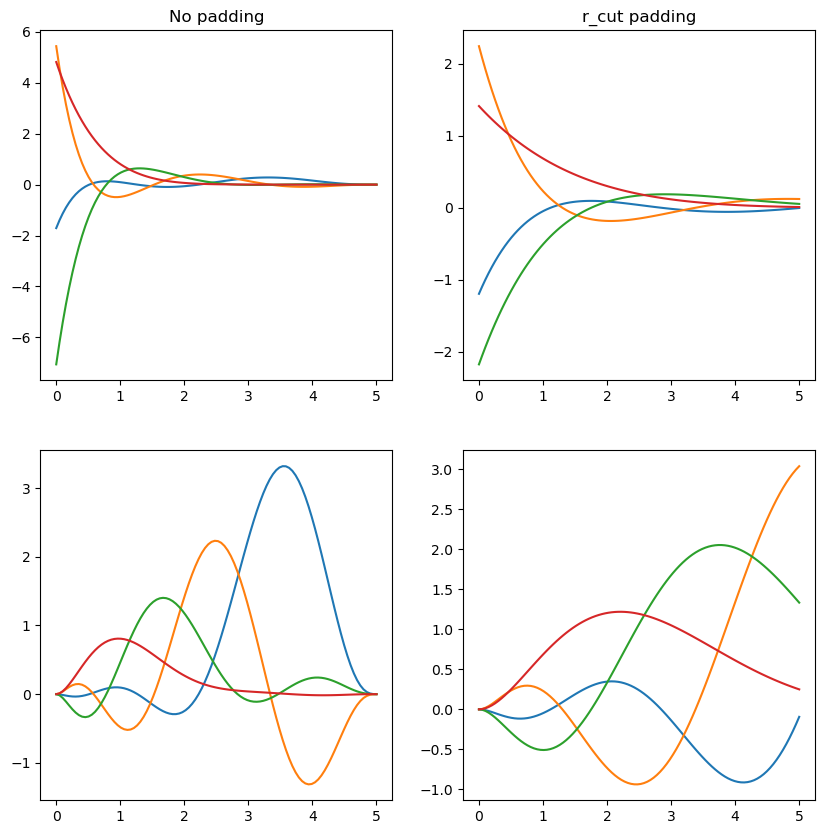

In [3]:
r_cut = 5
n_max = 4  # Number of radial basis functions
l_max = 5  # Maximum degree of spherical harmonics
rx = np.linspace(0, r_cut, 100)


rbf_no_pad = get_basis_poly(r_cut, n_max, rx, cut_pad=0)
rbf_pad = get_basis_poly(r_cut, n_max, rx, cut_pad=5)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].plot(rx, rbf_no_pad.T, label="No pad")
ax[0, 1].plot(rx, rbf_pad.T, label="Padded")
ax[1, 0].plot(rx, rbf_no_pad.T * rx[:, None]**2, label="Scaled No pad")
ax[1, 1].plot(rx, rbf_pad.T * rx[:, None]**2, label="Scaled Padded")

ax[0, 0].set_title("No padding"); ax[0, 1].set_title("r_cut padding")
plt.show()

In [4]:
r_cut = 5
n_max = 6  # Number of radial basis functions
l_max = 8  # Maximum degree of spherical harmonics

rho, atoms_positions, coords = get_density_feats(dens)  # NOTE: this transposes the density from FORTRAN to C order
coeffs, f, masks = lsq_sph_coeffs(rho, atoms_positions, coords, r_cut, l_max, n_max)

0
1
2
3
4
5
6
7
8
9
10
11
12


(<Figure size 1500x1000 with 6 Axes>,
 array([<Axes: xlabel='x', ylabel='y'>, <Axes: xlabel='x', ylabel='z'>,
        <Axes: xlabel='y', ylabel='z'>], dtype=object))

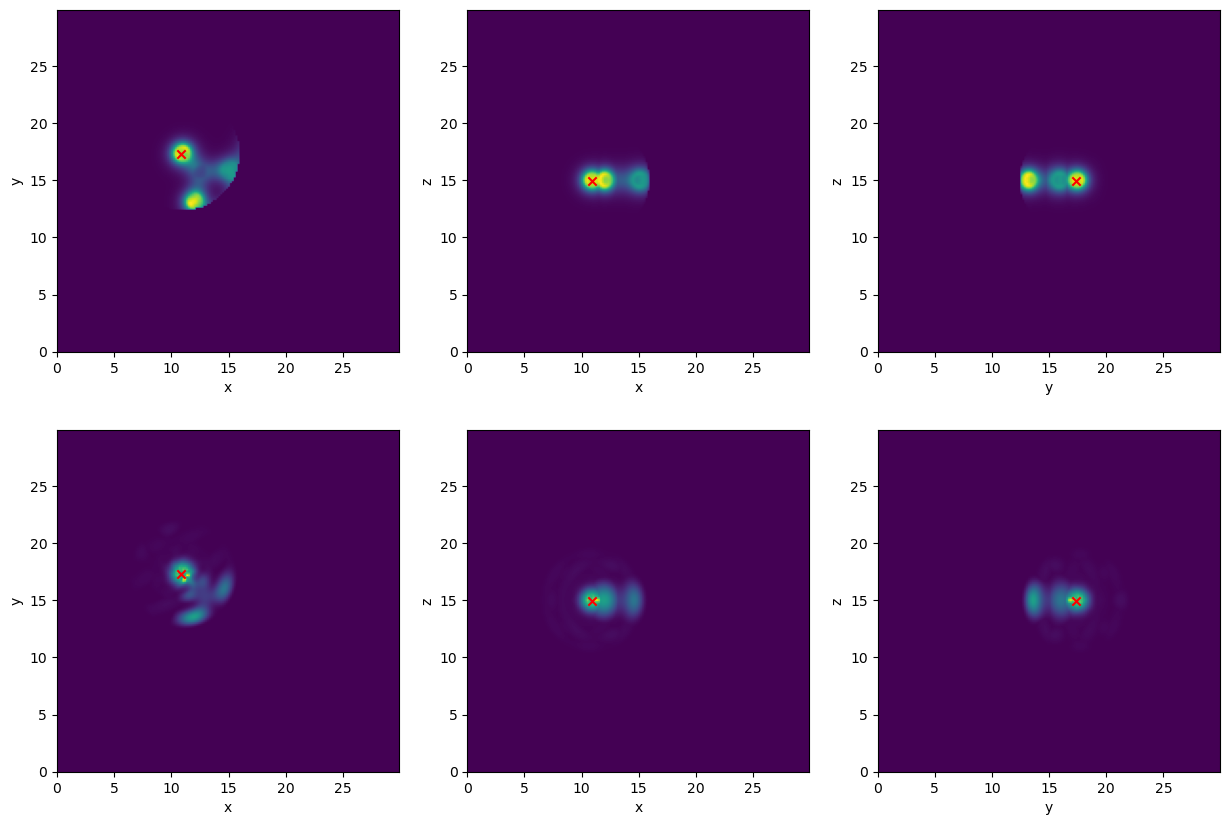

In [5]:
tst = np.zeros_like(rho)
tst[masks[0]] = f[0].T @ coeffs[0]

tst2 = np.zeros_like(rho)
tst2[masks[0]] = rho[masks[0]]


fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_density_projections(project_density(tst.T), atoms_positions[None, 0, :], dens.alat, ax=ax[1])
plot_density_projections(project_density(tst2.T), atoms_positions[None, 0, :], dens.alat, ax=ax[0])

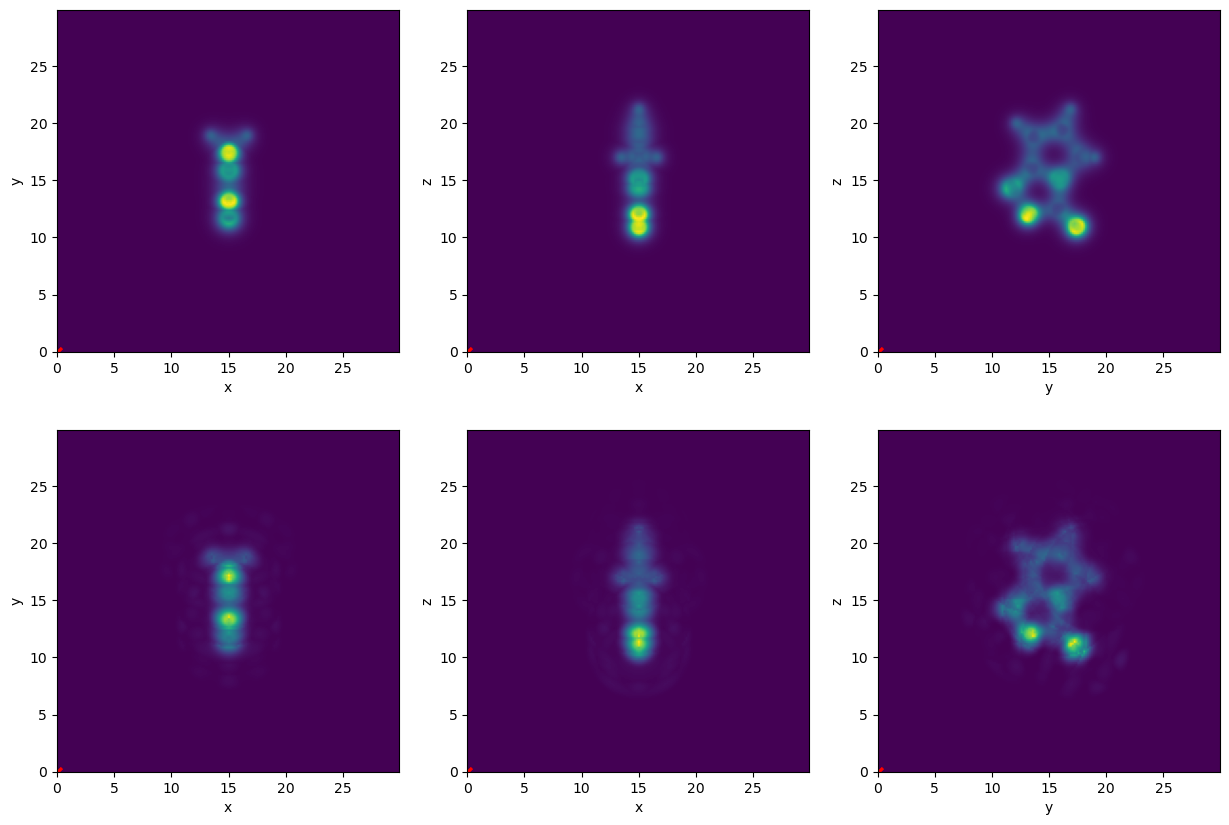

In [7]:
new_rho = reconstructor(f, masks, coeffs)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_density_projections(project_density(rho), dens.atoms_positions * 0, dens.alat, ax=ax[0])
plot_density_projections(project_density(new_rho), dens.atoms_positions * 0, dens.alat, ax=ax[1])
plt.show()

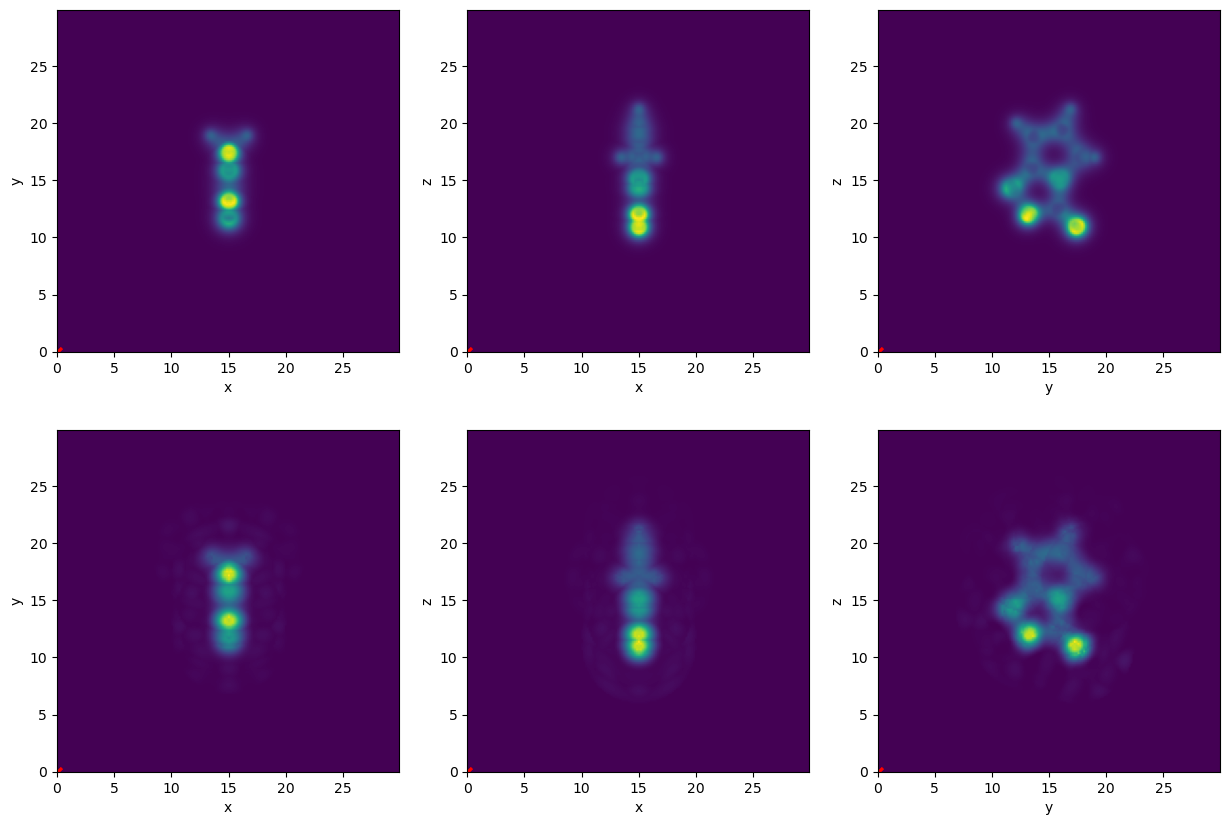

In [7]:
coeffs, f, masks = lsq_sph_coeffs(rho, atoms_positions, coords, r_cut, l_max, n_max, cut_pad=.5)
new_rho = reconstructor(f, masks, coeffs)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plot_density_projections(project_density(rho), dens.atoms_positions * 0, dens.alat, ax=ax[0])
plot_density_projections(project_density(new_rho), dens.atoms_positions * 0, dens.alat, ax=ax[1])
plt.show()

# Basis Comparison

In [8]:
r_cut = 5
n_maxs = [2, 4, 6, 8, 10, 11]  # Number of radial basis functions
l_maxs = [2, 4, 6, 8, 10, 15]  # Maximum degree of spherical harmonics

rho, atoms_positions, coords = get_density_feats(dens)  # NOTE: this transposes the density from FORTRAN to C order
coeffs, f, masks = lsq_sph_coeffs(rho, atoms_positions, coords, r_cut, l_max, n_max)

coeffs = []
f = []
masks = []
# for n_max, l_max in zip(n_maxs, l_maxs):
#     coeffs_, f_, masks_ = lsq_sph_coeffs(rho, atoms_positions, coords, r_cut, l_max, n_max)
#     coeffs.append(coeffs_)
#     f.append(f_)
#     masks.append(masks_)

In [ ]:
# load pickle
import pickle
with open("coeffs.pkl", "rb") as f:
    coeffs, f, masks = pickle.load(f)
with open("f.pkl", "rb") as f:
    f = pickle.load(f)
with open("masks.pkl", "rb") as f:
    masks = pickle.load(f)

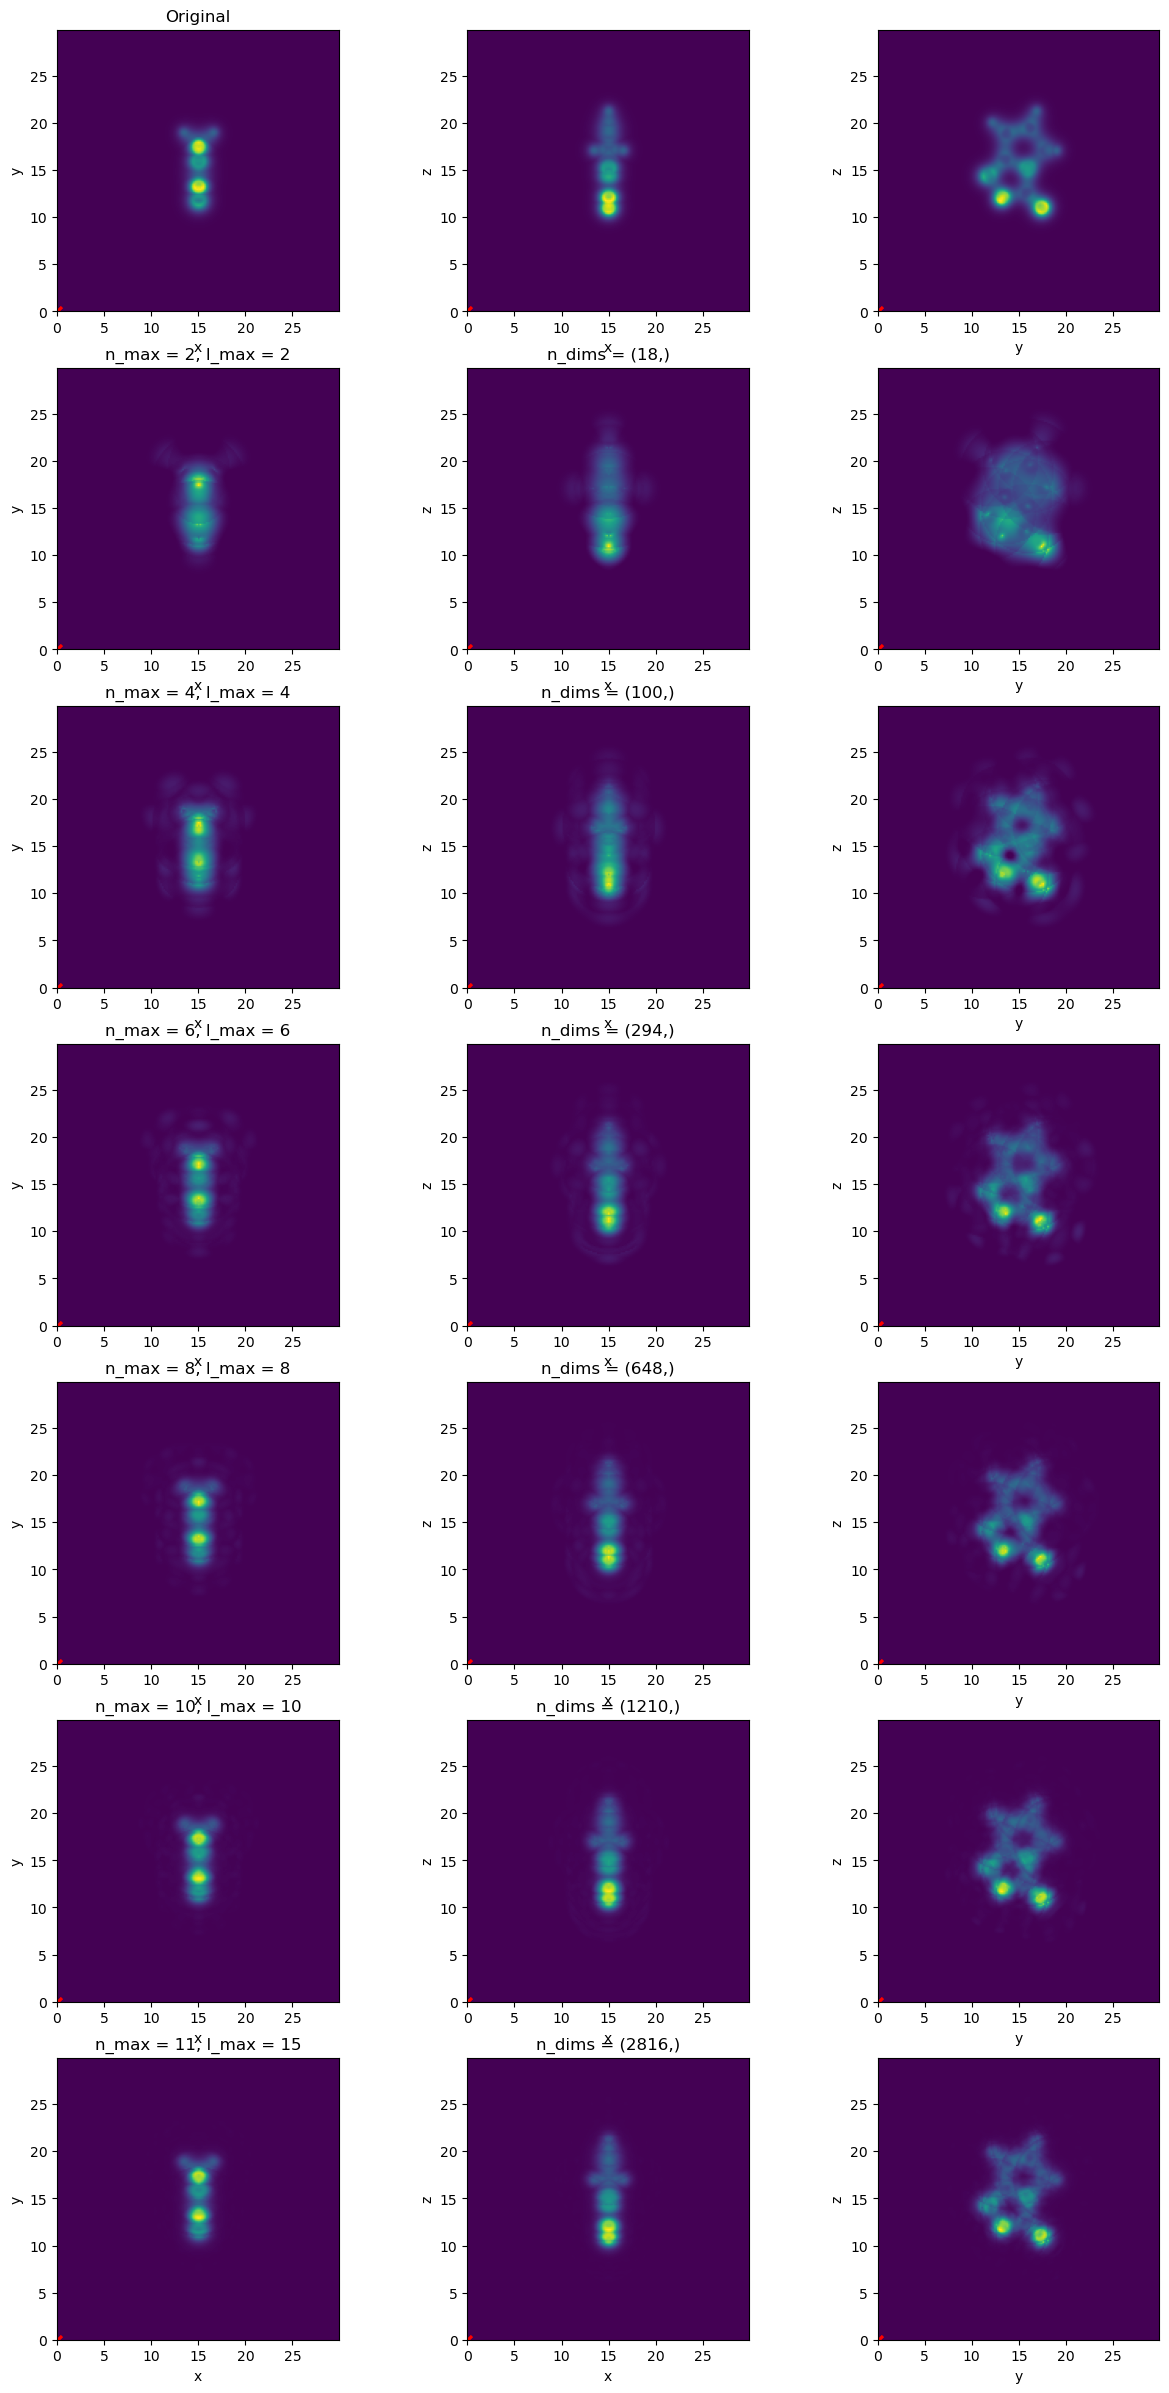

In [18]:
# plot results
fig, ax = plt.subplots(7, 3, figsize=(15, 30))
plot_density_projections(project_density(rho), dens.atoms_positions * 0, dens.alat, ax=ax[0])
ax[0, 0].set_title("Original")
for i, (n_max, l_max) in enumerate(zip(n_maxs, l_maxs)):
    new_rho = reconstructor(f[i], masks[i], coeffs[i])
    plot_density_projections(project_density(new_rho), dens.atoms_positions * 0, dens.alat, ax=ax[i + 1])
    ax[i + 1, 0].set_title(f"n_max = {n_max}, l_max = {l_max}")
    ax[i + 1, 1].set_title(f"n_dims = {coeffs[i][0].shape}")

In [ ]:
# # save to pickle
# import pickle
# with open("coeffs.pkl", "wb") as f2:
#     pickle.dump(coeffs, f2)
# with open("f.pkl", "wb") as f2:
#     pickle.dump(f, f2)
# with open("masks.pkl", "wb") as f2:
#     pickle.dump(masks, f2)

# Evaluation metrics
Our projection of the ED into local atom-centered spherical harmonics basis can be thought of as a form of lossy compression of an (3D) image. From a ($180^3 \approx 600,000$ pixel) image to a set of $n_{atoms}$ vectors in $\mathbb{R}^m$ where $m=(l_{max} + 1)^2\cdot n^{rbf}_{max}$.

For the training of our ML model we must strike a balance between the size and accuracy of our representation. To best choose the number of basis functions onto which project the ED we can simply compute and evaluate the fidelity of our compression with a metric.

Given the similarity of the problem we can borrow from work in the field of image processing when evalauating our compression algorithm. The first and most common evaluation metric is peak signal to noise ration (PSNR): which is essentially a scaled mean squared error (MSE):
$$
\text{PSNR} = 10 \cdot \log_{10}\left(\frac{{\text{Maximal Possible Pixel Value}^2}}{{\text{MSE}}}\right)
$$

The second is the Structural similarity (SSIM) is better because it takes the structure of the image and the errors into account in the measure.

$$
\text{SSIM}(x, y) = \frac{{(2 \cdot \mu_x \cdot \mu_y + C_1) \cdot (2 \cdot \sigma_{xy} + C_2)}}{{(\mu_x^2 + \mu_y^2 + C_1) \cdot (\sigma_x^2 + \sigma_y^2 + C_2)}}
$$
where,
$$

\begin{align*}
&\mu_x, \mu_y \text{ are the means of } x \text{ and } y, \\
&\sigma_x^2, \sigma_y^2 \text{ are the variances of } x \text{ and } y, \\
&\sigma_{xy} \text{ is the covariance of } x \text{ and } y, \\
&C_1, C_2 \text{ are small constants to stabilize the division.}
\end{align*}
$$

## Interpolation
We can test out our interpolation method. Right now we only use linear interpolation but in the future we can use something like cubic or rbf interpolation.

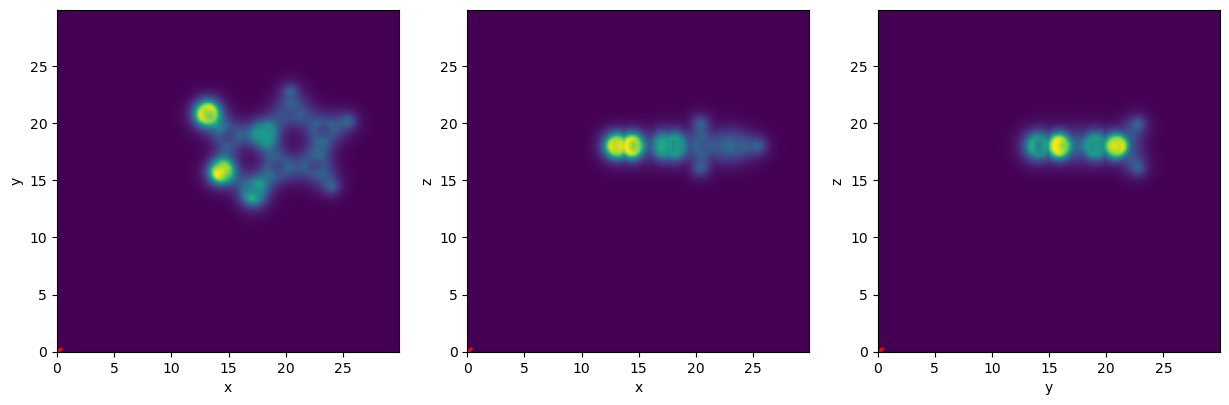

In [9]:
# Test out interpolation
coords2 = dens.get_coords() / 1.2
rho2 = interpolate_density(dens.get_coords(), dens.rho, coords2, method="linear")
ax = plot_density_projections(project_density(rho2), dens.atoms_positions * 0, dens.alat)

# Quadratures

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

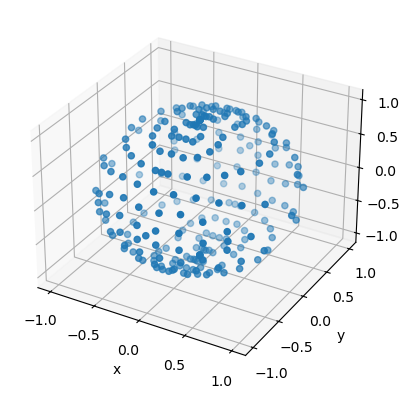

In [23]:
from quadratures import LebedevGrid

lebedev_quad = LebedevGrid(27)
lebedev_quad.plot()